You are already acquainted with Pytorch now as a fanstastic library for writing, modifying, testing and scaling up the code. In this notebook, let us learn a cool wrapper library for Pytorch known as Pytorch Lightning

A great resource to learn about the differences between Pytorch and Pytorch Lightning and how Pytorch Lightning makes your life easier : https://www.geeksforgeeks.org/deep-learning/pytorch-vs-pytorch-lightning/

Please note that according to this TA, you can`t really appreciate the resurcefulness of Pytorch lightning without learning the basics of Pytorch. Hence, take this tutorial as a 10,000 ft overview of what Pytorch and Pytorch lightning actually do. 

In [47]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from lightning import LightningModule, LightningDataModule, Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
import hydra
import torch.nn.functional as F
import random
import zstandard
import os
import glob
import io
import numpy as np
import xarray as xr
from torch.utils.data import Dataset, DataLoader, random_split
import rasterio
import rioxarray
from torch.utils.data import TensorDataset, DataLoader


The original paper this notebook is based on, can be accessed at https://gmd.copernicus.org/articles/18/2051/2025/ . There are originally 14 input channels to predict 2 chanels ultimately : temperature and wind speed. For the purposes of this notebook (due to storage limits and memory issues), we shall only be using low res 2m temperature to predict the high res 2m temperature target field.

 But to supplement our endeavours in the form of giving more data to the model, we will also feed in static inputs (inputs that do not change or evolve over time) which are 1. digital elevation model (DEM), 2. land cover categories and 3. latitude. The functions to do so can be found in the preprocessing file, and we import them here for ease of analysis. 

In [48]:
from preprocessing import decompress_zst_pt,load_static_tif,load_land_cover,get_file_list,collate_fn


Data : We are using hourly data from five years (2016-2020), with random split for training,validation and testing. This random splitting ensures a uniform distribution of samples across years, months, and hours of the day in all three datasets. 

In [49]:
class DownscalingDataset(Dataset):
    def __init__(self, file_list, static_vars):
        self.file_list = file_list
        self.static = static_vars

    def __len__(self):
        return len(self.file_list) * 24

    def __getitem__(self, idx):
        file_idx = idx // 24
        hour = idx % 24
        high_path, low_path, date = self.file_list[file_idx]
        high_data = decompress_zst_pt(high_path)
        low_data = decompress_zst_pt(low_path)
        # Extract only 2mT for the given hour
        high_2mt = high_data[hour]["2mT"].float().unsqueeze(0)
        low_2mt = low_data[hour]["2mT"].float().unsqueeze(0)
        # Optionally add static variables if needed
        dem = self.static["dem"].unsqueeze(0)
        lat = self.static["lat"].unsqueeze(0)
        lc = self.static["lc"]
        return {
            "low_2mT": low_2mt,
            "high_2mT": high_2mt,
            "dem": dem,
            "lat": lat,
            "lc": lc,
            "hour": hour,
            "date": date
        }


In [50]:
def get_dataloaders(batch_size=32, val_frac=0.15, test_frac=0.15, num_workers=4):
    dem = load_static_tif(os.path.join("DiffScaler/data/static_var/dtm_2km_domain_trim_EPSG3035.tif"))
    lat = load_static_tif(os.path.join("DiffScaler/data/static_var/lat_2km_domain_trim_EPSG3035.tif"))
    lc = load_land_cover(os.path.join("DiffScaler/data/static_var/land_cover_classes_2km_domain_trim_EPSG3035.tif"))
    static_vars = {"dem": dem, "lat": lat, "lc": lc}
    file_list = get_file_list()
    dataset = DownscalingDataset(file_list, static_vars)
    N = len(dataset)
    n_val = int(val_frac * N)
    n_test = int(test_frac * N)
    n_train = N - n_val - n_test
    train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
    return train_loader, val_loader, test_loader

In [51]:
train_loader, val_loader, test_loader = get_dataloaders(batch_size=32)

train_loader = DataLoader(train_loader.dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_loader.dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_loader.dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [52]:
class DownscalingDataModule(LightningDataModule):
    def __init__(self, train_loader, val_loader, test_loader):
        super().__init__()
        self._train_loader = train_loader
        self._val_loader = val_loader
        self._test_loader = test_loader

    def train_dataloader(self):
        return self._train_loader

    def val_dataloader(self):
        return self._val_loader

    def test_dataloader(self):
        return self._test_loader

    @property
    def test_dataset(self):
        return self._test_loader.dataset

# Instantiate
data_module = DownscalingDataModule(train_loader, val_loader, test_loader)

#Always check what your batches look like before proceeding with any training

In [53]:
sample_batch = next(iter(train_loader))
print("Debugging Batch Contents")
print(f"Batch type: {type(sample_batch)}")
if isinstance(sample_batch, tuple):
    print(f"Tuple length: {len(sample_batch)}")
    for i, item in enumerate(sample_batch):
        print(f"Item {i} shape: {item.shape if hasattr(item, 'shape') else type(item)}")

Debugging Batch Contents
Batch type: <class 'tuple'>
Tuple length: 2
Item 0 shape: torch.Size([32, 19, 672, 576])
Item 1 shape: torch.Size([32, 1, 672, 576])


First, we use a Unet for predicting of the high resolution target field. For this we need a hierarchy of models where the low resolution passes through the Unet first for predicting the mean of the high resolution target field, then the residuals (UNet pred minus the low res field) to be passed through the VAE and LDM for denoising and reconstruction, to generate new samples. 

In [54]:
class UNet(nn.Module):
    def __init__(self, in_channels=19, out_channels=1):
        super().__init__()
        
        # Simple refinement network - same resolution in/out
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.final = nn.Conv2d(32, out_channels, 1)
        
        self.dropout = nn.Dropout2d(0.1)
        
    def forward(self, x):
        # Simple feedforward refinement
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = self.dropout(h)
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        output = self.final(h)
        return output

In [55]:
class UNetLitModule(LightningModule):
    def __init__(
        self,
        net: torch.nn.Module = None,
        lr: float = 1e-3,
        optimizer: torch.optim.Optimizer = None,
        scheduler: torch.optim.lr_scheduler = None,
        loss_fn: torch.nn.Module = None,
        ckpt_path: str = None,
        ignore_keys: list = []
    ):
        super().__init__()
        
        self.save_hyperparameters(logger=False, ignore=['net', 'loss_fn'])
        
        # Initialise network with correct channels
        self.net = net if net is not None else UNet(in_channels=19, out_channels=1)
        
        self.loss_fn = loss_fn if loss_fn is not None else nn.MSELoss()
        
        self.lr = lr
    
    def forward(self, x):
        return self.net(x)
    
    def model_step(self, batch):
        if isinstance(batch, tuple) and len(batch) == 2:
            fuzzy_input = batch[0]    # [B, 19, 672, 576] upsampled t2m + HR static
            sharp_target = batch[1]   # [B, 1, 672, 576] HR t2m target
        elif isinstance(batch, dict):
            # Fallback for old format
            fuzzy_input = batch["low_2mT"]  
            sharp_target = batch["high_2mT"]
        else:
            raise ValueError(f"Unexpected batch format: {type(batch)}")
        
        pred = self.forward(fuzzy_input)
        
        loss = self.loss_fn(pred, sharp_target)
        return loss, pred
    
    def training_step(self, batch, batch_idx):
        loss, pred = self.model_step(batch)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss, pred = self.model_step(batch)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss, pred = self.model_step(batch)
        self.log("test/loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

Then we need the VAE and LDM classes for processing the sampling the residuals 

In [56]:
def kl_from_standard_normal(mean, log_var):
    """Calculate KL divergence from standard normal distribution."""
    kl = 0.5 * (log_var.exp() + mean.square() - 1.0 - log_var)
    return kl.mean()

def sample_from_standard_normal(mean, log_var, num=None):
    """Sample from normal distribution using reparameterization trick."""
    std = (0.5 * log_var).exp()
    shape = mean.shape
    if num is not None:
        shape = shape[:1] + (num,) + shape[1:]
        mean = mean[:,None,...]
        std = std[:,None,...]
    return mean + std * torch.randn(shape, device=mean.device)

In [58]:
class VAE(nn.Module):
    def __init__(self, latent_dim=32, input_channels=1, input_height=672, input_width=576):
        super().__init__()
        self.latent_dim = latent_dim
        self.input_height = input_height
        self.input_width = input_width

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, padding=1), 
            nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d(2),  # 336x288
            nn.Conv2d(16, 32, 3, padding=1), 
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),  # 168x144
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # 84x72
            nn.Flatten()
        )

        # Calculate flattened size after convolutions
        self.encoded_size = 64 * (self.input_height // 8) * (self.input_width // 8)  # 64 * 84 * 72

        # Latent space projections
        self.fc_mu = nn.Linear(self.encoded_size, latent_dim)
        self.fc_logvar = nn.Linear(self.encoded_size, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.encoded_size)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, self.input_height // 8, self.input_width // 8)),  # (64, 84, 72)
            nn.ConvTranspose2d(64, 32, 2, stride=2), 
            nn.BatchNorm2d(32), nn.ReLU(),  # 168x144
            nn.ConvTranspose2d(32, 16, 2, stride=2), 
            nn.BatchNorm2d(16), nn.ReLU(),  # 336x288
            nn.ConvTranspose2d(16, input_channels, 2, stride=2), 
            nn.Sigmoid()  # 672x576
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        return sample_from_standard_normal(mu, logvar)

    def decode(self, z):
        h = self.fc_decode(z)
        return self.decoder(h)

    def forward(self, x, sample_posterior=True):
        mu, logvar = self.encode(x)
        if sample_posterior:
            z = self.reparameterize(mu, logvar)
        else:
            z = mu
        recon = self.decode(z)
        return recon, mu, logvar

In [59]:
class VAELitModule(LightningModule):
    def __init__(
        self, 
        latent_dim=32, 
        lr=1e-3,
        kl_weight=0.001,
        input_channels=1,
        optimizer=None,
        scheduler=None,
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters(logger=False)
        self.model = VAE(latent_dim, input_channels)
        self.lr = lr
        self.kl_weight = kl_weight
        
    def forward(self, x, sample_posterior=True):
        return self.model(x, sample_posterior)
    
    def _loss(self, batch):
        noisy, clean = batch
        recon, mu, logvar = self.forward(clean)
        
        # Reconstruction loss (L1 for better stability)
        recon_loss = F.l1_loss(recon, clean)
        
        # KL divergence loss using improved calculation
        kl_loss = kl_from_standard_normal(mu, logvar)
        
        # Total loss
        total_loss = recon_loss + self.kl_weight * kl_loss
        
        return total_loss, recon_loss, kl_loss
        
    def training_step(self, batch, batch_idx):
        total_loss, recon_loss, kl_loss = self._loss(batch)
        
        self.log("train/loss", total_loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("train/recon_loss", recon_loss, on_step=True, on_epoch=True, sync_dist=True)
        self.log("train/kl_loss", kl_loss, on_step=True, on_epoch=True, sync_dist=True)
        
        return total_loss
        
    def validation_step(self, batch, batch_idx):
        total_loss, recon_loss, kl_loss = self._loss(batch)
        
        self.log("val/loss", total_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("val/recon_loss", recon_loss, on_step=False, on_epoch=True, sync_dist=True)
        self.log("val/kl_loss", kl_loss, on_step=False, on_epoch=True, sync_dist=True)
        
        return total_loss
    
    def test_step(self, batch, batch_idx):
        total_loss, recon_loss, kl_loss = self._loss(batch)
        
        self.log("test/loss", total_loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("test/recon_loss", recon_loss, on_step=False, on_epoch=True, sync_dist=True)
        self.log("test/kl_loss", kl_loss, on_step=False, on_epoch=True, sync_dist=True)
        
        return total_loss
        
    def configure_optimizers(self):
        if self.hparams.optimizer is not None:
            optimizer = self.hparams.optimizer(params=self.parameters())
        else:
            optimizer = torch.optim.AdamW(
                self.parameters(), 
                lr=self.lr,
                betas=(0.5, 0.9), 
                weight_decay=1e-3
            )
            
        if self.hparams.scheduler is not None:
            scheduler = self.hparams.scheduler(optimizer=optimizer)
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "val/recon_loss",
                    "interval": "epoch",
                    "frequency": 1,
                },
            }
        else:
            reduce_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, patience=3, factor=0.25
            )
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": reduce_lr,
                    "monitor": "val/recon_loss",
                    "frequency": 1,
                },
            }

LDM consistes of a UNet in latent space that is used to generate new samples from a standard gaussian distribution. 

In [60]:
class LatentDenoiser(nn.Module):
    def __init__(self, latent_dim=32, hidden_dim=128, num_layers=3):
        super().__init__()
        
        # Store latent_dim for proper input size calculation
        self.latent_dim = latent_dim
        
        # Simple timestep embedding - output size should match
        self.time_embed = nn.Sequential(
            nn.Linear(1, latent_dim), 
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim)
        )
        
        layers = []
        layers.append(nn.Linear(latent_dim * 2, hidden_dim))  # latent_dim + latent_dim for timestep
        layers.append(nn.ReLU())
        
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.LayerNorm(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))
        
        layers.append(nn.Linear(hidden_dim, latent_dim))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, z_noisy, timestep=None):
        if timestep is None:
            timestep = torch.zeros(z_noisy.shape[0], 1, device=z_noisy.device)
        
        if timestep.max() > 1.0:
            timestep = timestep / 1000.0
            
        t_embed = self.time_embed(timestep.float())
        
        # Concatenate latent and timestep embedding
        x = torch.cat([z_noisy, t_embed], dim=-1)
        
        return self.net(x)

In [61]:
class LDMLitModule(LightningModule):
    def __init__(
        self, 
        vae, 
        latent_dim=32, 
        lr=1e-3,
        num_timesteps=1000,
        noise_schedule="linear",
        loss_type="l2",
        optimizer=None,
        scheduler=None,
        **kwargs
    ):
        super().__init__()
        
        # Save hyperparameters
        self.save_hyperparameters(logger=False, ignore=['vae'])
        
        # Store VAE (frozen)
        self.vae = vae.model.requires_grad_(False)
        self.vae.eval()
        
        # Initialize denoiser
        self.denoiser = LatentDenoiser(latent_dim)
        
        # Training parameters
        self.lr = lr
        self.num_timesteps = num_timesteps
        self.loss_type = loss_type
        
        # Initialize noise schedule
        self.register_noise_schedule(noise_schedule)
        
        # Loss function
        if loss_type == "l1":
            self.loss_fn = nn.L1Loss()
        elif loss_type == "l2":
            self.loss_fn = nn.MSELoss()
        else:
            raise ValueError(f"Unknown loss type: {loss_type}")

    def register_noise_schedule(self, schedule="linear"):
        """Register noise schedule for diffusion process."""
        if schedule == "linear":
            betas = torch.linspace(1e-4, 2e-2, self.num_timesteps)
        elif schedule == "cosine":
            timesteps = torch.arange(self.num_timesteps + 1) / self.num_timesteps
            alphas = torch.cos(timesteps * torch.pi / 2) ** 2
            alphas = alphas / alphas[0]
            betas = 1 - alphas[1:] / alphas[:-1]
            betas = torch.clamp(betas, 0, 0.999)
        else:
            raise ValueError(f"Unknown schedule: {schedule}")
        
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        
        self.register_buffer('betas', betas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1 - alphas_cumprod))

    def q_sample(self, x_start, t, noise=None):
        """Add noise to clean latent according to diffusion schedule."""
        if noise is None:
            noise = torch.randn_like(x_start)
        
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
        
        return (sqrt_alphas_cumprod_t * x_start + 
                sqrt_one_minus_alphas_cumprod_t * noise)

    def p_losses(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        
        # Add noise to clean latent
        x_noisy = self.q_sample(x_start, t, noise)
        
        # Predict noise
        predicted_noise = self.denoiser(x_noisy, t.unsqueeze(1))
        
        # Calculate loss
        loss = self.loss_fn(predicted_noise, noise)
        
        return loss

    def forward(self, x):
        batch_size = x.shape[0]
        
        # Encode to latent space
        with torch.no_grad():
            mu, logvar = self.vae.encode(x)
            z = self.vae.reparameterize(mu, logvar)
        
        # Sample random timesteps
        t = torch.randint(0, self.num_timesteps, (batch_size,), device=self.device)
        
        # Calculate diffusion loss
        loss = self.p_losses(z, t)
        
        return loss

    def training_step(self, batch, batch_idx):
        noisy, clean = batch
        loss = self.forward(clean)
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss
        
    def validation_step(self, batch, batch_idx):
        noisy, clean = batch
        loss = self.forward(clean)
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        noisy, clean = batch
        loss = self.forward(clean)
        self.log("test/loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    @torch.no_grad()
    def sample(self, shape, num_steps=50):
        # Start with pure noise
        z = torch.randn(shape, device=self.device)
        
        # Sampling timesteps
        timesteps = torch.linspace(self.num_timesteps-1, 0, num_steps, dtype=torch.long, device=self.device)
        
        for i, t in enumerate(timesteps):
            t_batch = t.repeat(shape[0])
            
            # Predict noise
            predicted_noise = self.denoiser(z, t_batch.unsqueeze(1))
            
            # Denoise step 
            alpha_t = self.alphas_cumprod[t]
            alpha_t_prev = self.alphas_cumprod[t-1] if t > 0 else torch.tensor(1.0)

            # Denoised prediction
            pred_x0 = (z - torch.sqrt(1 - alpha_t) * predicted_noise) / torch.sqrt(alpha_t)
            
            if t > 0:
                noise = torch.randn_like(z) if i < len(timesteps) - 1 else 0
                z = (torch.sqrt(alpha_t_prev) * pred_x0 + 
                     torch.sqrt(1 - alpha_t_prev) * noise)
            else:
                z = pred_x0
        
        return z

    @torch.no_grad()
    def generate_samples(self, num_samples=1):
        latent_shape = (num_samples, self.hparams.latent_dim)
        z_samples = self.sample(latent_shape)
        
        samples = self.vae.decode(z_samples)
        
        return samples

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.lr,
            betas=(0.5, 0.9), 
            weight_decay=1e-3
        )
        return optimizer

In [62]:
cfg = OmegaConf.load("conf/config_experiments.yaml")
print(OmegaConf.to_yaml(cfg))

model:
  unet:
    in_channels: 19
    out_channels: 1
    lr: 0.001
  vae:
    latent_dim: 64
    input_channels: 1
    input_height: 672
    input_width: 576
    lr: 0.001
    kl_weight: 0.001
  ldm:
    latent_dim: 64
    lr: 0.0001
    num_timesteps: 50
    noise_schedule: linear
    loss_type: l2
    hidden_dim: 128
    num_layers: 4
trainer:
  max_epochs: 10
  min_delta: 0.0001
  accelerator: auto
training:
  unet_epochs: 10
  vae_epochs: 10
  ldm_epochs: 10
data:
  batch_size: 32
  train_split: 0.7
  val_split: 0.2
  test_split: 0.1
optimizer:
  unet:
    type: Adam
    lr: 0.001
    weight_decay: 0.0001
  vae:
    type: AdamW
    lr: 0.001
    betas:
    - 0.5
    - 0.9
    weight_decay: 0.001
  ldm:
    type: AdamW
    lr: 0.0001
    betas:
    - 0.5
    - 0.9
    weight_decay: 0.001
scheduler:
  unet:
    type: ReduceLROnPlateau
    patience: 5
    factor: 0.5
    monitor: val/loss
  vae:
    type: ReduceLROnPlateau
    patience: 3
    factor: 0.25
    monitor: val/reconstruc

In [63]:
def train_hierarchy(cfg):
    train_loader, val_loader, test_loader = get_dataloaders(
        batch_size=cfg.data.batch_size,
        val_frac=cfg.data.val_split,
        test_frac=cfg.data.test_split
    )
    data_module = DownscalingDataModule(train_loader, val_loader, test_loader)
    checkpoint_dir = cfg.paths.checkpoint_dir
    os.makedirs(checkpoint_dir, exist_ok=True)


#First we train the UNet  to get an initial fuzzy (mean) prediction
    unet_module = UNetLitModule(
        net=UNet(
            in_channels=cfg.model.unet.in_channels,
            out_channels=cfg.model.unet.out_channels
        ),
        lr=cfg.model.unet.lr
    )
    unet_checkpoint = ModelCheckpoint(
        dirpath=checkpoint_dir + "/unet",
        filename="unet-{epoch:02d}-{val_loss:.4f}",
        save_top_k=1,
        monitor="val/loss",
        mode="min"
    )
    trainer_unet = Trainer(
        max_epochs=cfg.training.unet_epochs,
        accelerator=cfg.trainer.accelerator,
        enable_checkpointing=True,
        logger=False,
        callbacks=[unet_checkpoint]
    )
    trainer_unet.fit(unet_module, datamodule=data_module)


#Then we generate residuals from the prediction of the Unet (difference between target and prediction)
    residuals = []
    for batch in data_module.train_dataloader():
        fuzzy_input, sharp_target = batch
        with torch.no_grad():
            pred = unet_module.net(fuzzy_input)
            residual = sharp_target - pred
            residuals.append(residual)
    residuals = torch.cat(residuals, dim=0)

    #These residuals are going to be now encoded into latent space using the VAE
    vae_module = VAELitModule(
    latent_dim=cfg.model.vae.latent_dim,
    lr=cfg.model.vae.lr,
    kl_weight=cfg.model.vae.kl_weight,
    input_channels=cfg.model.vae.input_channels,
    input_height=cfg.model.vae.input_height,
    input_width=cfg.model.vae.input_width
)
    vae_checkpoint = ModelCheckpoint(
        dirpath=checkpoint_dir + "/vae",
        filename="vae-{epoch:02d}-{val_loss:.4f}",
        save_top_k=1,
        monitor="val/loss",
        mode="min"
    )
    residual_dataset = TensorDataset(residuals, residuals)
    residual_data_module = DownscalingDataModule(
        DataLoader(residual_dataset, batch_size=cfg.data.batch_size),
        DataLoader(residual_dataset, batch_size=cfg.data.batch_size),
        DataLoader(residual_dataset, batch_size=cfg.data.batch_size)
    )
    trainer_vae = Trainer(
        max_epochs=cfg.training.vae_epochs,
        accelerator=cfg.trainer.accelerator,
        enable_checkpointing=True,
        logger=False,
        default_root_dir=checkpoint_dir + "/vae",
        callbacks=[vae_checkpoint]
    )
    trainer_vae.fit(vae_module, datamodule=residual_data_module)

    # These encoded latent residuals will then be denoised using a UNet in latent space itself. 
    ldm_module = LDMLitModule(
        vae=vae_module,
        latent_dim=cfg.model.ldm.latent_dim,
        lr=cfg.model.ldm.lr,
        num_timesteps=cfg.model.ldm.num_timesteps,
        noise_schedule=cfg.model.ldm.noise_schedule,
        loss_type=cfg.model.ldm.loss_type
    )
    ldm_checkpoint = ModelCheckpoint(
        dirpath=checkpoint_dir + "/ldm",
        filename="ldm-{epoch:02d}-{val_loss:.4f}",
        save_top_k=1,
        monitor="val/loss",
        mode="min"
    )
    trainer_ldm = Trainer(
        max_epochs=cfg.training.ldm_epochs,
        accelerator=cfg.trainer.accelerator,
        enable_checkpointing=True,
        logger=False,
        default_root_dir=checkpoint_dir + "/ldm",
        callbacks=[ldm_checkpoint]
    )
    trainer_ldm.fit(ldm_module, datamodule=residual_data_module)



In [ ]:
#How will you train the model hierarchy based on the configurations provided?

train_hierarchy(cfg)


/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/.micromamba/envs/diffscaler/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/D ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | net     | UNet    | 75.7 K | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
75.7 K    Trainable params
0         Non-trainable params
75.7 K    Total params
0.303     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 48/48 [01:06<00:00,  0.72it/s, train/loss_step=0.037, val/loss=0.041, train/loss_epoch=0.0454]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 48/48 [01:06<00:00,  0.72it/s, train/loss_step=0.037, val/loss=0.041, train/loss_epoch=0.0454]


In [ ]:
def inference(cfg):
    train_loader, val_loader, test_loader = get_dataloaders(
        batch_size=cfg.data.batch_size,
        val_frac=cfg.data.val_split,
        test_frac=cfg.data.test_split
    )
    data_module = DownscalingDataModule(train_loader, val_loader, test_loader)
    checkpoint_dir = cfg.paths.checkpoint_dir

    # Load best checkpoints from each step of the hierarchy
    unet_module = UNetLitModule.load_from_checkpoint(
        os.path.join(checkpoint_dir, "unet", sorted(os.listdir(checkpoint_dir + "/unet"))[-1])
    )
    vae_module = VAELitModule.load_from_checkpoint(
        os.path.join(checkpoint_dir, "vae", sorted(os.listdir(checkpoint_dir + "/vae"))[-1])
    )
    ldm_module = LDMLitModule.load_from_checkpoint(
        os.path.join(checkpoint_dir, "ldm", sorted(os.listdir(checkpoint_dir + "/ldm"))[-1]),
        vae=vae_module
    )

    test_dataset = data_module.test_dataset

    # Set modules to evaluation mode
    unet_module.eval()
    vae_module.eval()
    ldm_module.eval()

    # Select a single random test sample
    idx = random.randint(0, len(test_dataset)-1)
    sample = test_dataset[idx]
    if isinstance(sample, dict):
        fuzzy_input = torch.cat([
            F.interpolate(sample["low_2mT"].unsqueeze(0), size=sample["high_2mT"].shape[-2:], mode='bilinear', align_corners=False),
            sample["dem"].unsqueeze(0),
            sample["lat"].unsqueeze(0),
            sample["lc"].unsqueeze(0)
        ], dim=1).squeeze(0)
        sharp_target = sample["high_2mT"]
    else:
        fuzzy_input, sharp_target = sample

    with torch.no_grad():
        device = next(unet_module.parameters()).device
        fuzzy_input = fuzzy_input.unsqueeze(0).to(device)
        unet_pred = unet_module.net(fuzzy_input)
        # Generate 3 samples of residuals
        generated_residuals = ldm_module.generate_samples(num_samples=3)
        final_reconstructions = unet_pred + generated_residuals
        final_reconstructions = final_reconstructions.clamp(0, 1)

    plt.figure(figsize=(30, 5))
    plt.subplot(1, 6, 1)
    plt.title("Original High-Res")
    plt.imshow(sharp_target[0].cpu().numpy(), cmap='viridis')  # Use 'viridis' for temperature
    plt.colorbar()
    plt.axis('off')

    plt.subplot(1, 6, 2)
    plt.title("Low-Res Input (Upsampled)")
    plt.imshow(fuzzy_input[0, 0].cpu().numpy(), cmap='viridis')  # Use 'viridis'
    plt.colorbar()
    plt.axis('off')

    plt.subplot(1, 6, 3)
    plt.title("UNet Prediction")
    plt.imshow(unet_pred[0, 0].cpu().numpy(), cmap='viridis')
    plt.colorbar()
    plt.axis('off')

    # Show three generated samples
    for i in range(3):
        plt.subplot(1, 6, 4+i)
        plt.title(f"Sample {i+1}")
        plt.imshow(final_reconstructions[i, 0].cpu().numpy(), cmap='viridis')
        plt.colorbar()
        plt.axis('off')

    plt.suptitle("Single Test Sample: 3 Generated High-Res Outputs")
    plt.tight_layout()
    plt.show()

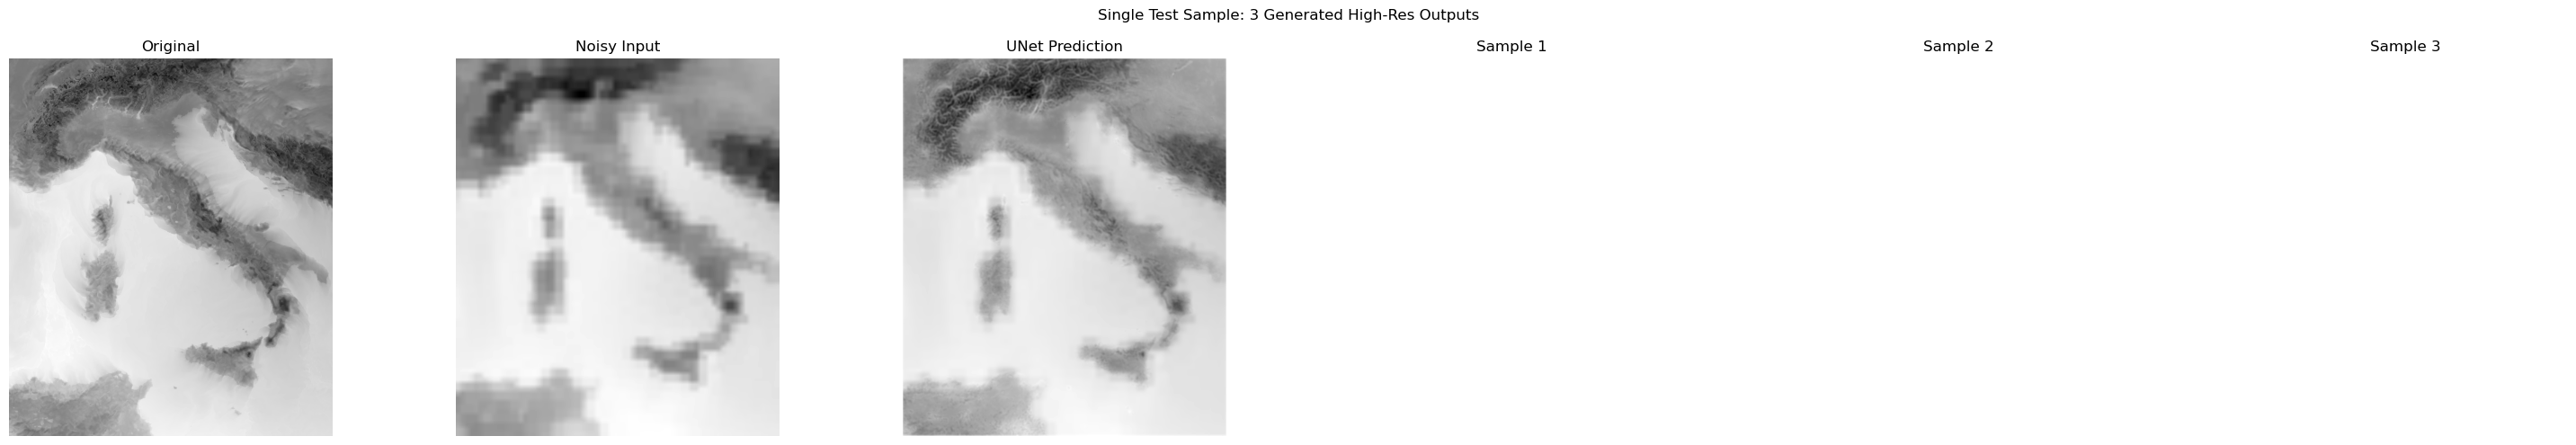

In [27]:
#Now that the models are trained,,, how will you perform inference using the trained hierarchy?

inference(cfg)

Part II : Hydra : the one stop solution to all your experimental needs !!

In [ ]:
import hydra
from omegaconf import DictConfig, OmegaConf

@hydra.main(config_path="conf", config_name="config_experiments.yaml")
def main(cfg: DictConfig):
    print(OmegaConf.to_yaml(cfg))
    train_hierarchy(cfg)
    inference(cfg)

if __name__ == "__main__":
    main()